In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp
from jax.image import scale_and_translate

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import PI, get_wavelen, apply_psf, simulate_projection, xpci_2matdecomp
# from src.spectral_xpci.crlb import crlb_2matdecomp_sq
from chromatix.ops import init_plane_resample

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False)
    ax.add_artist(scalebar)

# CRLB tests

In [2]:
## misc. old params, for reference
   
# mat1, p1, t1 = 'Al(100.0)', 2.699, 0.3e-3  
# mat2, p2, t2 = 'H(11.2)O(88.8)', 1.0, 1.1e-3
# mat1, p1, t1 = 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)', 1.06, 1e-3  # ICRU tissue
# mat2, p2, t2 = 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)', 1.92, 1e-3   # ICRU bone

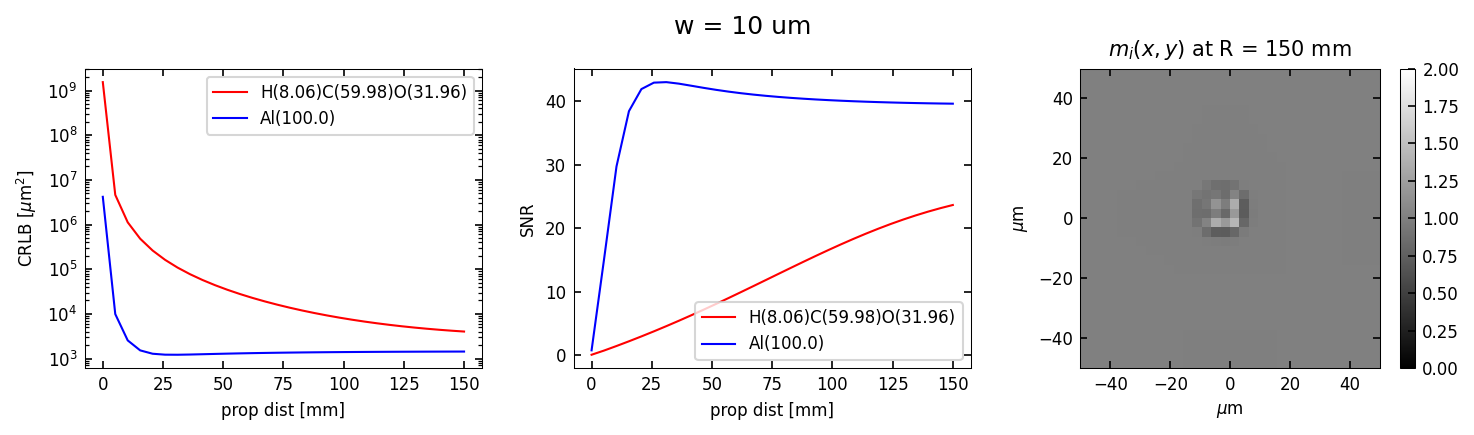

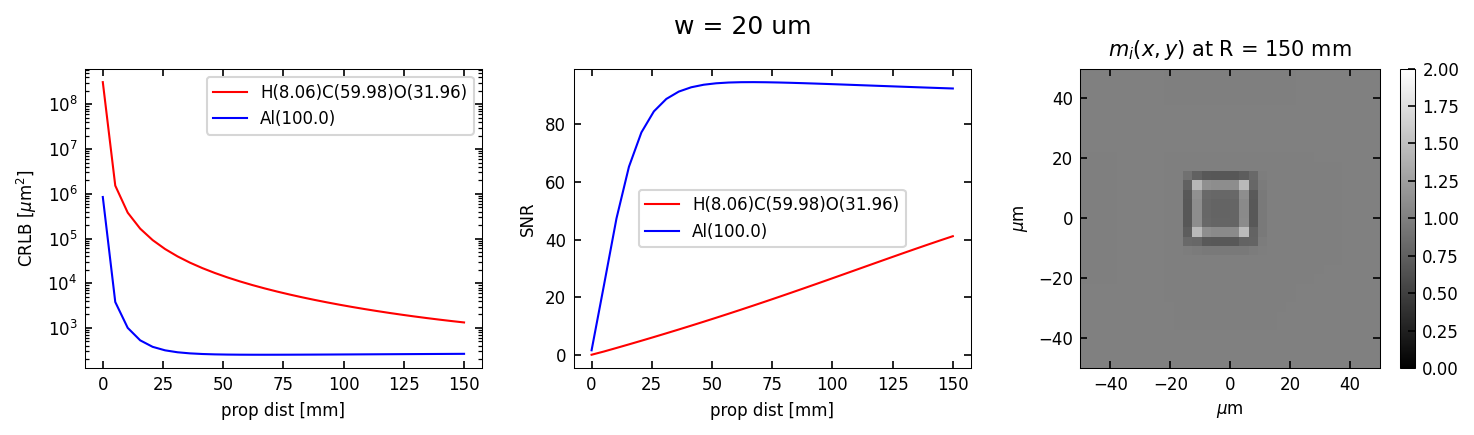

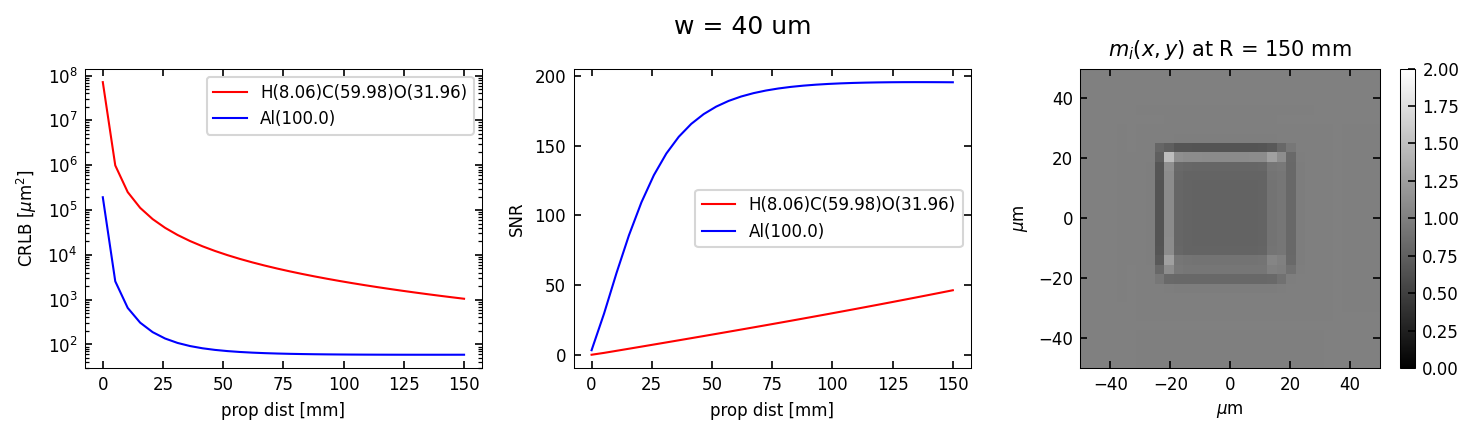

CPU times: user 20.2 s, sys: 2.13 s, total: 22.4 s
Wall time: 23.1 s


In [3]:
%%time 

propdists = np.linspace(0, 150e-3, 30)    # [m]
energies = np.array([24.0, 34.0])  
I0 = 1e3       #photons per detector pixel
fov = 100e-6  
phantom_Nx = 128  
det_Nx = 32
det_fwhm = 1e-6

mat1, p1, t1 = 'H(8.06)C(59.98)O(31.96)', 1.19, 1.5e-3   # PMMA
mat2, p2, t2 = 'Al(100.0)', 2.699, 1.5e-3


#####################
#####################

mat1_dn, mat1_beta = get_delta_beta_mix(mat1, energies, p1)
mat2_dn, mat2_beta = get_delta_beta_mix(mat2, energies, p2)
phantom_shape = (phantom_Nx, phantom_Nx)
phantom_px = fov / phantom_Nx
det_shape = (det_Nx, det_Nx)           
det_px = fov / det_shape[0]   
matinfo1 = [mat1, p1, t1]
matinfo2 = [mat2, p2, t2]
mus = 2 * (2 * PI / get_wavelen(energies)) * jnp.array([mat1_beta, mat2_beta])
ds = jnp.array([mat1_dn, mat2_dn])

def detect_img(x, in_px=phantom_px, out_shape=det_shape, out_px=det_px, det_fwhm=det_fwhm, normalize=False):
    """
    create the detector resampling function
    this should be applied to both signals m and partials dm/dt before the Fisher info calc.
    """
    scale = jnp.array([in_px/out_px, in_px/out_px])
    translation = -0.5 * (scale*jnp.array(x.shape) - jnp.array(out_shape))
    total = x.sum()
    x = scale_and_translate(x, out_shape, (0,1), scale, translation, method='linear')
    if normalize:
        x = x * (total / x.sum())
    if det_fwhm is not None:
        x = apply_psf(x, x.shape[0]*out_px, out_px, fwhm=det_fwhm, psf='lorentzian', kernel_width=0.1)
    return x
    
#####################
#####################

for w in [10e-6, 20e-6, 40e-6]: 
    
    kx = np.fft.fftfreq(phantom_Nx, d=phantom_px)
    KX, KY = np.meshgrid(kx, kx)
    sinc2D = w**2 * np.sinc(w*KX) * np.sinc(w*KY) / phantom_px**2  # normalize rect amplitude = 1
    K2 = KX**2 + KY**2  

    def get_Aij(E_i, R_i, mat_j, p_j):
        delta_ij, beta_ij = get_delta_beta_mix(mat_j, E_i, p_j)
        mu_ij = 2 * (2 * PI / get_wavelen(E_i)) * beta_ij
        return mu_ij - (R_i * K2 * delta_ij) 
    
    def get_mi(E_i, R_i, matinfo1, matinfo2, I0):
        mat1, p1, t1 = matinfo1
        mat2, p2, t2 = matinfo2
        Ai1 = get_Aij(E_i, R_i, mat1, p1)
        Ai2 = get_Aij(E_i, R_i, mat2, p2)  
        iFT = np.fft.fftshift(np.fft.ifft2(sinc2D * (Ai1*t1 + Ai2*t2))).real
        return I0 * np.exp(-detect_img(iFT, det_fwhm=det_fwhm))
        
    def get_dmi_dAij(mi, Aij):
        iFT = np.fft.fftshift(np.fft.ifft2(sinc2D * Aij)).real
        return mi * detect_img(iFT, det_fwhm=det_fwhm)  
    
    ### get CRLB!
    crlb1 = []
    crlb2 = []
    for R in propdists:
        F = np.zeros([2,2])
        for i in range(len(energies)):
            E_i = energies[i]
            R_i = R
            mi = get_mi(E_i, R, matinfo1, matinfo2, I0)
            dmi_dA1 = get_dmi_dAij(mi, get_Aij(E_i, R_i, matinfo1[0], matinfo1[1]))
            dmi_dA2 = get_dmi_dAij(mi, get_Aij(E_i, R_i, matinfo2[0], matinfo2[1]))
            F[0,0] += np.sum(dmi_dA1**2 / mi)
            F[0,1] += np.sum(dmi_dA1 * dmi_dA2 / mi)
            F[1,0] += np.sum(dmi_dA2 * dmi_dA1 / mi)
            F[1,1] += np.sum(dmi_dA2**2 / mi)
        crlbs = np.linalg.diagonal(np.linalg.inv(F))
        snrs = np.array([t1, t2]) / np.sqrt(crlbs)
        crlb1.append(crlbs[0])
        crlb2.append(crlbs[1])
        # print(crlbs, snrs)

    crlb1, crlb2 = np.array(crlb1), np.array(crlb2)
    propdists_mm = propdists*1e3
    fig, ax = plt.subplots(1, 3, figsize=[10,3])
    fig.suptitle(f'w = {w*1e6:.0f} um', y=0.95)
    ax[0].plot(propdists_mm, crlb1*1e12, 'r-', label=mat1)
    ax[0].plot(propdists_mm, crlb2*1e12, 'b-', label=mat2)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('CRLB [$\mu$m$^2$]')
    ax[1].plot(propdists_mm, matinfo1[2]/np.sqrt(crlb1), 'r-', label=mat1)
    ax[1].plot(propdists_mm, matinfo2[2]/np.sqrt(crlb2), 'b-', label=mat2)
    ax[1].set_ylabel('SNR')

    for axi in ax[:-1]:
        axi.set_xlabel('prop dist [mm]')
        axi.legend()
    ax[-1].set_title(f'$m_i(x,y)$ at R = {R_i*1e3:.0f} mm')
    m = ax[-1].imshow(mi/I0, vmin=0, vmax=2, extent=1e6*np.array([-fov,fov,-fov,fov])/2)
    ax[-1].set_xlabel('$\mu$m')
    ax[-1].set_ylabel('$\mu$m')
    fig.colorbar(m, ax=ax[-1])
    fig.tight_layout()
    plt.show()

# Simulation tests

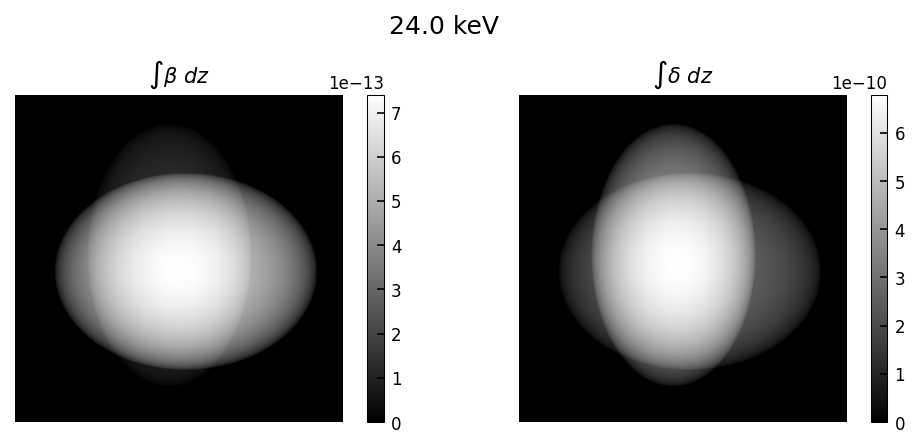

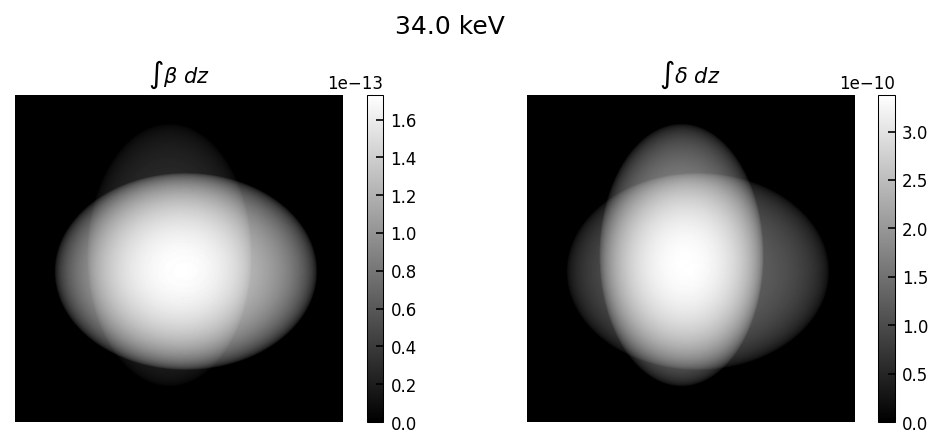

In [4]:
# make projections

energies = jnp.array([24.0, 34.0])  

fov = 1e-3 
phantom_Nx = 512
   
mat1, p1 = 'Al(100.0)', 2.699
mat2, p2 = 'H(11.2)O(88.8)', 1.0
mat1_dn, mat1_beta = get_delta_beta_mix(mat1, energies, p1)
mat2_dn, mat2_beta = get_delta_beta_mix(mat2, energies, p2)
mus = 2 * (2 * PI / get_wavelen(energies)) * jnp.array([mat1_beta, mat2_beta])
ds = jnp.array([mat1_dn, mat2_dn])

t1 = 0.3e-3   #0.1 * fov 
t2 = 1.1e-3   #0.9 * fov   

phantom_shape = [phantom_Nx, phantom_Nx]  # assume isotropic
phantom_px = fov / phantom_shape[0]

### WEAK EDGE PHANTOM
tmap1 = jnp.sum(jnp.load('vol1_512.npy'), axis=0)
tmap2 = jnp.sum(jnp.load('vol2_512.npy'), axis=0)
tmap1 *= t1 / jnp.max(tmap1)
tmap2 *= t2 / jnp.max(tmap2)

### STRONG EDGE PHANTOM
# tmap1, tmap2 = jnp.zeros([2, phantom_shape[0], phantom_shape[1]])
# x = jnp.arange(-fov/2, fov/2, phantom_px) + phantom_px/2
# X, Y = jnp.meshgrid(x, x)
# tmap1 = tmap1.at[(3*X/fov)**2 + (4*Y/fov)**2 <= 1].set(t1)
# tmap2 = tmap2.at[(4*X/fov)**2 + (3*Y/fov)**2 <= 1].set(t2)

for e, E in enumerate(energies):
    
    beta_proj = mat1_beta[e]*tmap1 + mat2_beta[e]*tmap2
    dn_proj = mat1_dn[e]*tmap1 + mat2_dn[e]*tmap2
    
    fig, ax = plt.subplots(1, 2, figsize=[7,3])
    fig.suptitle(f'{E} keV')
    for i, stuff in enumerate(zip([beta_proj, dn_proj],['$\int \\beta ~dz$', '$\int \\delta ~dz$'])):
        im, ttl = stuff
        m = ax[i].imshow(im)
        fig.colorbar(m, ax=ax[i])
        ax[i].axis('off')
        ax[i].set_title(ttl)
    fig.tight_layout()
    plt.show()

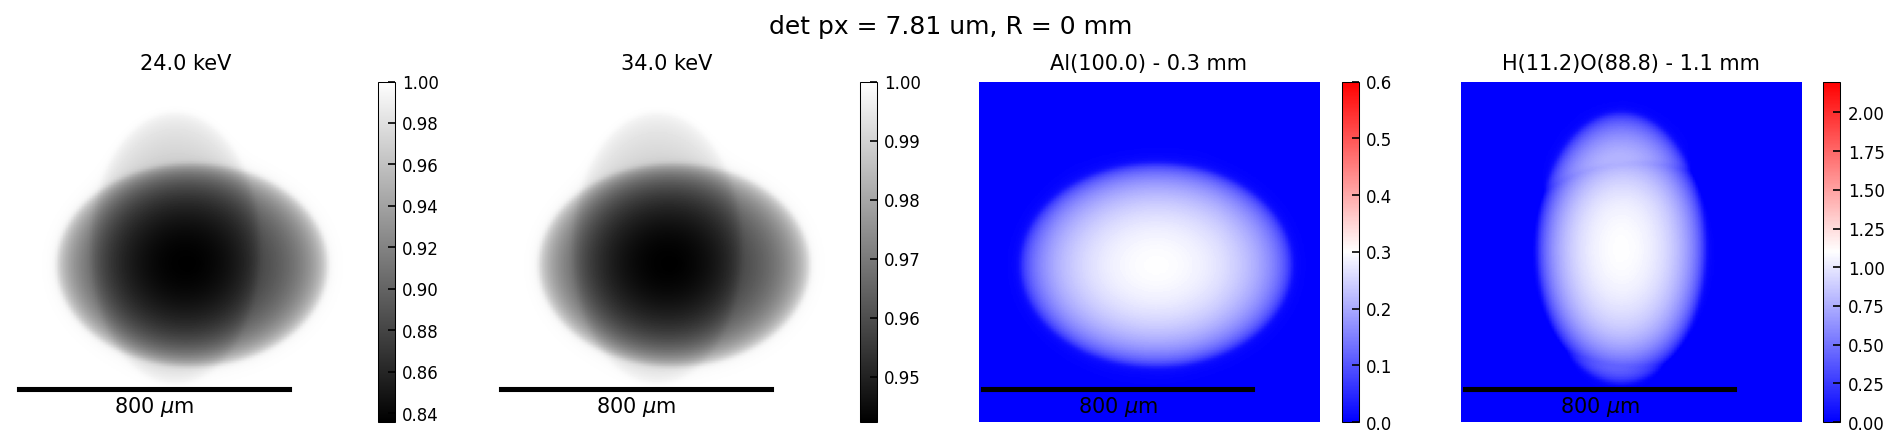

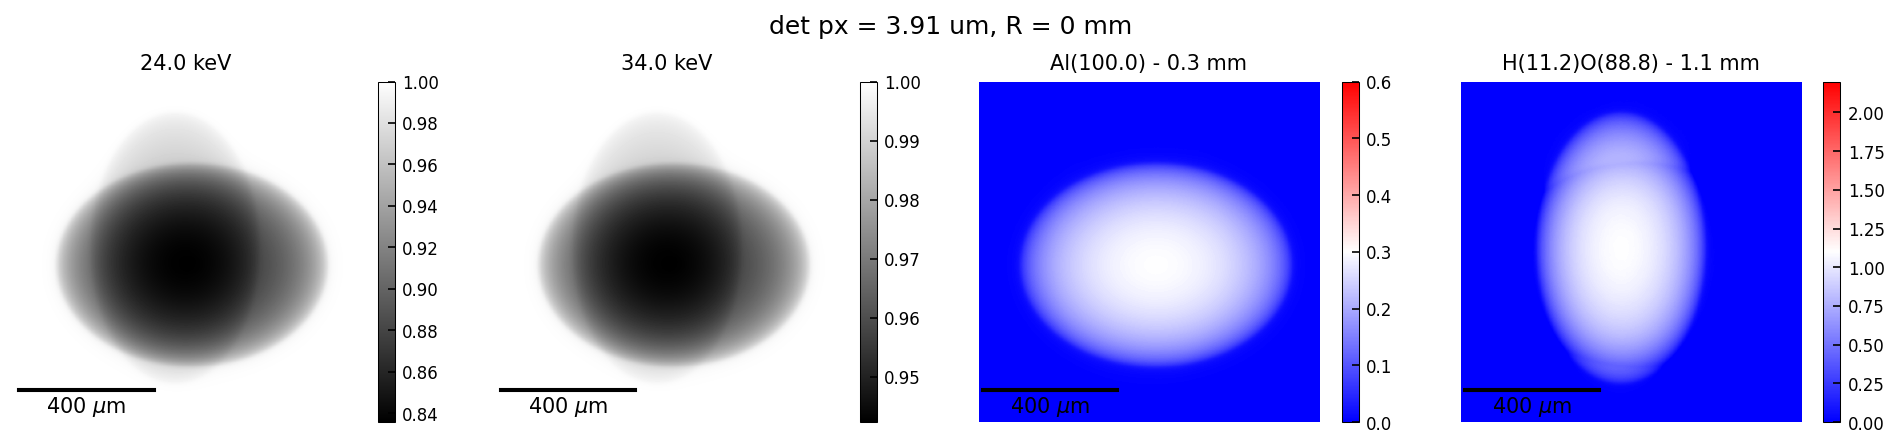

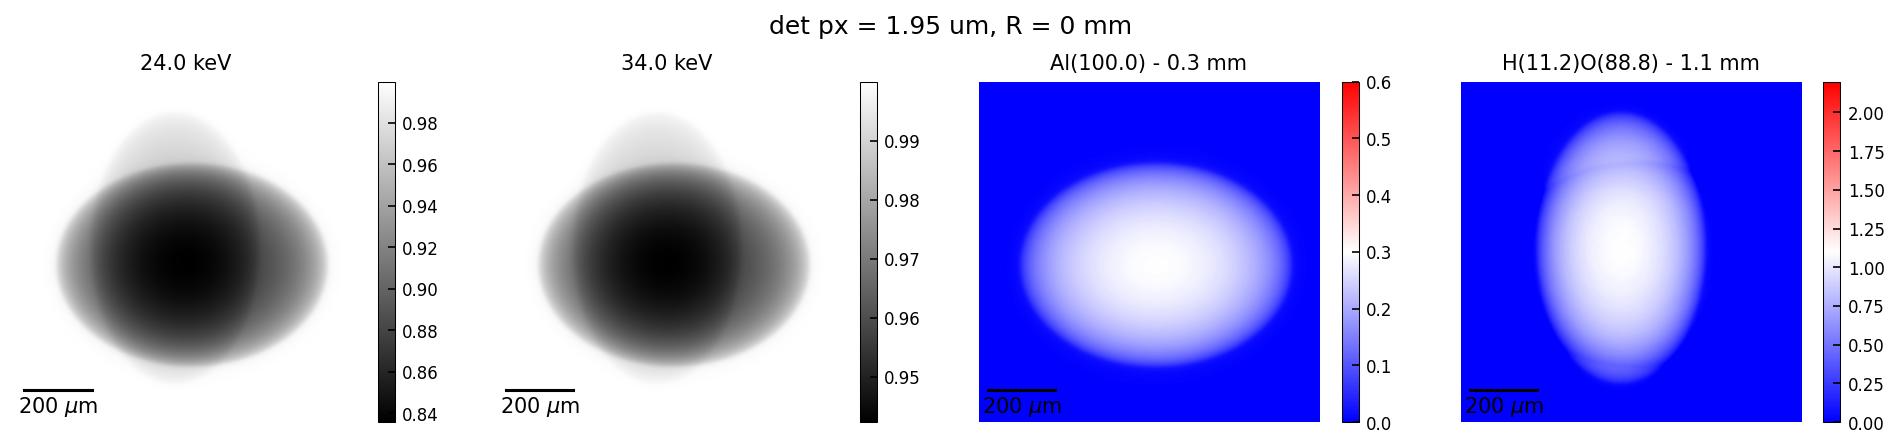

CPU times: user 9.48 s, sys: 609 ms, total: 10.1 s
Wall time: 15.2 s


In [5]:
%%time

I0 = 1e15    # photons per m^2
# R = 200e-3
# det_Nx = 128

for R in [0]:#, 50e-3, 200e-3]:
    for det_Nx in [128, 256, 512]:
        det_shape = (det_Nx, det_Nx)           
        det_px = fov / det_shape[0]    # as pixel size reduces/ det shape increases, the success of matdecomp reduces!
        det_fwhm = 10e-6  #det_px 
        I0_scaled = None  #I0 * (det_px**2)
        
        imgs = []
        for e, E in enumerate(energies):
            beta_proj = mat1_beta[e]*tmap1 + mat2_beta[e]*tmap2
            dn_proj = mat1_dn[e]*tmap1 + mat2_dn[e]*tmap2
            img = simulate_projection(beta_proj, dn_proj, phantom_px, det_shape, det_px, det_fwhm, E, R, I0_scaled)
            imgs.append(img)
        imgs = jnp.array(imgs)
        mat_imgs = xpci_2matdecomp(imgs, det_px, R, mus, ds)
        
        
        fig, ax = plt.subplots(1, 4, figsize=[13,3])
        for i in range(2):
            m = ax[i].imshow(imgs[i])
            fig.colorbar(m, ax=ax[i])
            ax[i].set_title(f'{energies[i]} keV')
            m = ax[i+2].imshow(mat_imgs[i]*1e3, vmin=0, vmax=[t1, t2][i]*2e3, cmap='bwr')
            fig.colorbar(m, ax=ax[i+2])
            ax[i+2].set_title(f'{[mat1, mat2][i]} - {[t1, t2][i]*1e3:.1f} mm')
        for i in range(4):
            ax[i].axis('off')
            add_scalebar(ax[i], 0.2, im.shape[0], det_px*1e6, '$\\mu$m')
        fig.suptitle(f'det px = {det_px*1e6:.2f} um, R = {R*1e3:.0f} mm')
        fig.tight_layout()
        plt.show()
